<a href="https://colab.research.google.com/github/A-R-Yazdi/Remote-communities-/blob/code_review/Data_Preprocessing_LingJun_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# input dataset
input_file = "/content/drive/MyDrive/all_combined_training.csv"
validation_file = "/content/drive/MyDrive/all_combined_validation.csv"
model_root= "/content/drive/MyDrive/Colab Notebooks/models/"
data_root="/content/drive/MyDrive/Colab Notebooks/data/"
fig_root='/content/drive/MyDrive/Colab Notebooks/figs/'
package_root='/content/drive/MyDrive/Colab Notebooks/packages/'
root='/content/drive/MyDrive/Colab Notebooks/'
# TODO: XGBoost parameters

In [ ]:
# %%capture suppresses the large output
%%capture
!pip install matplotlib>=3.1.3
!pip install statsmodels>=0.12.2
!pip install sktime
!pip install pmdarima>=1.8.2
!pip install sktime[all_extras]

In [104]:
import pandas as pd

class Preprocessing:
    def __init__(self):
        pass
    
    def create_key(self, keyString='df', keyRange=9):
        """ create a list of dataframe names, key=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']
        keyString is the invariable in the key, e.g. 'df' in 'df1'
        """
        key=[]
        for i in range(9):
            key.append(keyString+str(i+1))
        return key

    dfc = None
    def create_valuelist(self, DF=dfc, col='lat'):
        list_of_df= []
        col_val_list = list(DF[col].value_counts().keys())
        # print(col_val_list)
        for col_val in col_val_list:
            list_of_df.append(DF[DF[col]==col_val].reset_index(drop=True))
        return list_of_df


    def load_n_sort(self, df='df2'):
        df = pd.read_csv(data_root+df+".csv", index_col = 0)
        df = df.sort_values(by='datetime', ascending=True)
        return df


    def load_dframes(self, df_name='df', prop="", df_enum_range=range(1,10)):
        # print('preloading')
        if isinstance(df_enum_range, range) and isinstance(df_name, str):
            # print("loading....")
            for i in df_enum_range:
              n = df_name+str(i)+prop
              # use globals() to convert a string into var name so that we can use later
              globals()[n] = self.load_n_sort(n)
    
    def show_missing_datetime(self, diff_from: pd.DataFrame, start_d="2013-01-01", end_d="2016-01-01", freq='H'):
        """input var diff_from has to be a DataFrame with no duplications"""
        if isinstance(diff_from, pd.DataFrame) and len(diff_from[diff_from.duplicated()])==0:
            diff_from['datetime'] = pd.to_datetime(diff_from['datetime'])
            diff = pd.date_range(start=start_d, end=end_d, freq=freq)[:-1].difference(diff_from['datetime'])
            return diff
    
    def fill_missing_rows(self, df=df8):
        """input must be a dataframe"""
        if isinstance(df, pd.DataFrame):
            df['datetime'] = pd.to_datetime(df['datetime'])
            additional_df = pd.DataFrame(index=self.show_missing_datetime(diff_from=df), columns=df.columns)
            df = df.set_index('datetime').append(additional_df).sort_index(ascending=True).ffill().reset_index()
            df['datetime'] = df['index']
        
        return df.drop(['index'], axis=1)

    def show_shape(self, df_name='df', iterate=range(1,10), prop=""):
        shape = []
        for i in iterate:
            # name = 'df'+str(i) 
            name = globals()[df_name+str(i)+prop]
            shape.append(name.shape)
        df = pd.DataFrame(shape, columns=['num_of_rows', 'num_of_cols'], index = [df_name+str(i)+prop for i in range(1,10)])
        return df
    
    df3 = None
    def show_outliers(self, df=df3, col_name='kw_cap', num_of_std=3, anomaly_window=24*365*3):
        """
        df needs to be a DataFrame, col_name needs to be a string, num_of_std is an integer
        num_of_std decides the window of NORMAL values
        anomaly_window is the window size from which we decide the mean, std
        """
        # if isinstance(df, pd.DataFrame) & isinstance(col_name, str) & isinstance(num_of_std, int):
        #   pass
        # else:
        #   print("params need to be the correct type")
        
        d_outliers = pd.DataFrame(columns=df.columns)
        
        # if the row number is less than anomaly_window, take the first anomaly_window number of rows and calculate the mean, std
        dd = df[:anomaly_window]
        d_mean = dd[col_name].mean()
        d_std = dd[col_name].std()
        low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
        d_outliers = pd.concat([d_outliers, dd[(dd[col_name]< low) | (dd[col_name] > high)]])

        # if anomaly_window < len(df), this means d_mean, d_std changes row by row after we go beyond row number anomaly_window
        dd = df[anomaly_window:]
        for row in range(anomaly_window, len(df)):
            d_mean = df[col_name][row-anomaly_window:row].mean()
            d_std = df[col_name][row-anomaly_window:row].std()
            low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
            if (dd[col_name][row]<low)|(dd[col_name][row]>high):
              d_outliers = pd.concat([d_outliers, df[row:row+1]])

        return d_outliers

    def replace_outliers(self, df=df3, col_name: str='kw_cap', num_of_std : int=3, anomaly_window : int =24*365*3):
        """
        df needs to be a DataFrame, col_name needs to be a string, num_of_std is an integer
        num_of_std decides the window of NORMAL values
        anomaly_window is the window size from which we decide the mean, std
        """
        # index is the outliers row number
        index =  show_outliers(df=df, col_name=col_name, anomaly_window=anomaly_window, num_of_std=num_of_std).index
        
        for i in index:

            if i < anomaly_window:
            # if the row number is less than anomaly_window, take the first anomaly_window number of rows and calculate the mean, std
              dd = df[:anomaly_window]
              d_mean = dd[col_name].mean()
              d_std = dd[col_name].std()
              low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
              df[col_name][i] = d_mean
            
            else:
              dd = df[anomaly_window:]
              for row in range(anomaly_window, len(df)):
                  d_mean = df[col_name][row-anomaly_window:row].mean()
                  d_std = df[col_name][row-anomaly_window:row].std()
                  low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
                  df[col_name][i] = d_mean

        return df

In [107]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load

sns.set()
plt.style.use('bmh')
Preprocessing =  Preprocessing()

In [33]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()
dfc['datetime'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
dfc['kw_cap'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
52706,2013,1,7,2,866.81925,62.20071,-75.65000,1483,1347.844242,-33.108893,2013-01-07 02:00:00,2013-01-07,0.584504
157092,2015,12,7,12,339.60000,62.41657,-77.91644,414,384.150178,-22.287894,2015-12-07 12:00:00,2015-12-07,0.820290


## Split the dataframe by location and sort by datetime

In [34]:
dfc['lat'].value_counts()
# len(dfc['lat'].value_counts()) # 9

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

We see that there are some missing values in two of the DFs. They are missing by exactly `24*2=48` hours, or 2 days.

In [43]:
key = Preprocessing.create_key()
val_list = Preprocessing.create_valuelist(DF=dfc)

In [55]:
my_dict = dict(zip(key, val_list))
# my_dict['df1']['lat'] == my_dict['df7']['lat']
my_dict['df8']

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
0,2013,1,1,0,1314.522302,55.27987,-77.75458,686,1984.209328,-16.415625,2013-01-01 00:00:00,2013-01-01,1.916213
1,2013,1,1,1,1295.379198,55.27987,-77.75458,686,1984.209328,-17.082617,2013-01-01 01:00:00,2013-01-01,1.888308
2,2013,1,1,2,1281.408115,55.27987,-77.75458,686,1984.209328,-16.936621,2013-01-01 02:00:00,2013-01-01,1.867942
3,2013,1,1,3,1229.595401,55.27987,-77.75458,686,1984.209328,-17.152701,2013-01-01 03:00:00,2013-01-01,1.792413
4,2013,1,1,4,1184.894563,55.27987,-77.75458,686,1984.209328,-17.600867,2013-01-01 04:00:00,2013-01-01,1.727252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26227,2015,12,30,19,1908.782893,55.27987,-77.75458,686,1984.209328,-14.112158,2015-12-30 19:00:00,2015-12-30,2.782482
26228,2015,12,30,20,1848.980827,55.27987,-77.75458,686,1984.209328,-13.717383,2015-12-30 20:00:00,2015-12-30,2.695307
26229,2015,12,30,21,1804.852158,55.27987,-77.75458,686,1984.209328,-14.427344,2015-12-30 21:00:00,2015-12-30,2.630980
26230,2015,12,30,22,1810.590632,55.27987,-77.75458,686,1984.209328,-14.681250,2015-12-30 22:00:00,2015-12-30,2.639345


## Save the data for later use

In [ ]:
for name in list(my_dict.keys()):
  # print(name)
  my_dict[name].to_csv(data_root+ name+".csv")

## Load data & sort values

In [52]:
df2 = Preprocessing.load_n_sort('df2')
df2.head(3)
# df2.info()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
0,2013,1,1,0,849.450417,62.20071,-75.65,1483,1347.844242,-19.559714,2013-01-01 00:00:00,2013-01-01 00:00:00,0.572792
1,2013,1,1,1,891.025667,62.20071,-75.65,1483,1347.844242,-19.994040,2013-01-01 01:00:00,2013-01-01 00:00:00,0.600826
2,2013,1,1,2,905.738833,62.20071,-75.65,1483,1347.844242,-19.779135,2013-01-01 02:00:00,2013-01-01 00:00:00,0.610748


In [53]:
df1=Preprocessing.load_n_sort('df1').groupby('datetime')['kw_cap'].sum().reset_index()
# df1['date'].value_counts()
df1.sample(2)

,datetime,kw_cap
23208,2015-08-26 00:00:00,0.480096
1929,2013-03-22 09:00:00,0.649510


## Check duplicated and fill missing values

In [371]:
Preprocessing.load_dframes()
Preprocessing.show_shape()

,num_of_rows,num_of_cols
df1,26280,13
df2,26280,13
df3,26280,13
df4,26280,13
df5,26280,13
df6,26280,13
df7,26280,13
df8,26232,13
df9,26232,13


In [372]:
# there is a duplicated datetime for df6, but no duplicated rows (we can verify this by removing the ['datetime'] col from print() statement)
for i in range(1,10):
  df = vars()['df'+str(i)]
  print(df['datetime'].duplicated().sum())

0
0
0
0
0
1
0
0
0


In [373]:
# If we run the following line, we see that df6 is missing '2014-01-05 00:00:00'
# df6['datetime'][8855:8860]
for i in range(1,10):
  df = vars()['df'+str(i)]
  print(Preprocessing.show_missing_datetime(diff_from=df).shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(1,)
(0,)
(48,)
(48,)


__We may not want to drop the duplicated row in this case, because the duplication is not in the entire, but only on the datetime, this just means there is an error in the data entry. We just need to change to the correct datetime.__

In [374]:
# this line will show the row with duplicated datetime
df6[df6['datetime'].duplicated()]

df6['datetime'][8832] = pd.to_datetime('2014-01-05 00:00:00', infer_datetime_format=True)

for i in range(1,10):
  df = vars()['df'+str(i)]
  s = df['datetime'].duplicated().sum()
  if s == 0:
    pass
  else:
    print(s)

for i in range(1,10):
  df = vars()['df'+str(i)]
  print(Preprocessing.show_missing_datetime(diff_from=df).shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(48,)
(48,)


In [375]:
Preprocessing.fill_missing_rows(df=df1).head(3)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,1029.780250,58.45424,-78.10301,1757,1662.3844,-18.211905,2013-01-01 00:00:00,0.586101,2013-01-01 00:00:00
1,2013,1,1,1,1017.671833,58.45424,-78.10301,1757,1662.3844,-18.678336,2013-01-01 00:00:00,0.579210,2013-01-01 01:00:00
2,2013,1,1,2,987.965167,58.45424,-78.10301,1757,1662.3844,-18.978430,2013-01-01 00:00:00,0.562302,2013-01-01 02:00:00


In [376]:
for i in range(1,10):
  globals()['df'+str(i)] = Preprocessing.fill_missing_rows(df=locals()['df'+str(i)])

# If there are still missing rows in any dataframe, the return will be none null
for i in range(1,10):
  m = Preprocessing.show_missing_datetime(diff_from=locals()['df'+str(i)])
  if len(m)>0:
    print(m)
    print()

__This block only needs to run once!__

In [365]:
# for i in range(1,10):
#   vars()['df'+str(i)].to_csv(data_root+ 'df'+str(i)+"_filled.csv")

__======================================================__

In [379]:
Preprocessing.load_dframes(df_name='df', prop="_filled")
Preprocessing.show_shape(df_name='df', prop="_filled")

,num_of_rows,num_of_cols
df1_filled,26280,13
df2_filled,26280,13
df3_filled,26280,13
df4_filled,26280,13
df5_filled,26280,13
df6_filled,26280,13
df7_filled,26280,13
df8_filled,26280,13
df9_filled,26280,13


In [382]:
for i in range(1,10):
  df = vars()['df'+str(i)+"_filled"]
  s = df['datetime'].duplicated().sum()
  if s == 0:
    pass
  else:
    print('df'+str(i)+'has duplicated datetime'+ s)

for i in range(1,10):
  df = vars()['df'+str(i)+"_filled"]
  print(Preprocessing.show_missing_datetime(diff_from=df).shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


## Replace outliers

In [92]:
Preprocessing.load_dframes(df_name='df', prop="_filled")
Preprocessing.show_shape(df_name='df', prop="_filled")

,num_of_rows,num_of_cols
df1_filled,26280,13
df2_filled,26280,13
df3_filled,26280,13
df4_filled,26280,13
df5_filled,26280,13
df6_filled,26281,13
df7_filled,26280,13
df8_filled,26280,13
df9_filled,26280,13


__Sanity check__: ensure show_outliers() returns the same results when anomaly_window is 3 years long, 

In [ ]:
for i in range(1, 10):
  df = globals()['df'+str(i)]
  num_of_std =3
  col_name='kw_cap'
  anomaly_window = 365*3*24

  d_mean = df[col_name][:anomaly_window].mean()
  d_std = df[col_name][:anomaly_window].std()
  low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
  # the result has to be only False 
  print(False in list(df[(df[col_name]< low) | (df[col_name] > high)].index == show_outliers(df=df, anomaly_window=anomaly_window).index))

False
False
False
False
False
False
False
False
False


In [ ]:
for i in range(1,10):
  print("df"+ str(i)+ "_filled_ number of outliers when anomaly_window is 3 yrs long: " + str(show_outliers(df=locals()['df'+str(i)+"_filled_"]).shape[0]))

# show_outliers(df=df1, num_of_std=3)

df1_filled_ number of outliers when anomaly_window is 3 yrs long: 0
df2_filled_ number of outliers when anomaly_window is 3 yrs long: 2
df3_filled_ number of outliers when anomaly_window is 3 yrs long: 45
df4_filled_ number of outliers when anomaly_window is 3 yrs long: 26
df5_filled_ number of outliers when anomaly_window is 3 yrs long: 50
df6_filled_ number of outliers when anomaly_window is 3 yrs long: 6
df7_filled_ number of outliers when anomaly_window is 3 yrs long: 12
df8_filled_ number of outliers when anomaly_window is 3 yrs long: 214
df9_filled_ number of outliers when anomaly_window is 3 yrs long: 4


In [ ]:
df3_filled_.shape
show_outliers(df=df3_filled_).shape
replace_outliers(df=df3_filled_).shape
show_outliers(df=replace_outliers(df=df3_filled_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
16864,2014,12,4,16,487.0,61.03,-69.62,403,463.473224,-7.692236,2014-12-04 00:00:00,1.208437,2014-12-04 16:00:00
16888,2014,12,5,16,487.0,61.03,-69.62,403,463.473224,-14.377783,2014-12-05 00:00:00,1.208437,2014-12-05 16:00:00


__Sanity check__: I would think this should return all 0s, however, because the **mean, std** both change everytime we change a value in a series, after we replace the outliers with **mean**, the new series will have different __mean,st__, which might lead to none-0 results

In [ ]:
for i in range(1,10):
  anomaly_window = 24*365*3
  leng = len(show_outliers(df=replace_outliers(df=locals()['df'+str(i)+"_filled_"], anomaly_window=anomaly_window), anomaly_window=anomaly_window))
  print("number of outliers in df"+str(i)+"_filled_: "+str(leng))

number of outliers in df1_filled_: 0
number of outliers in df2_filled_: 0
number of outliers in df3_filled_: 8
number of outliers in df4_filled_: 5
number of outliers in df5_filled_: 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number of outliers in df6_filled_: 0
number of outliers in df7_filled_: 1
number of outliers in df8_filled_: 0
number of outliers in df9_filled_: 0


## Hourly resolution

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


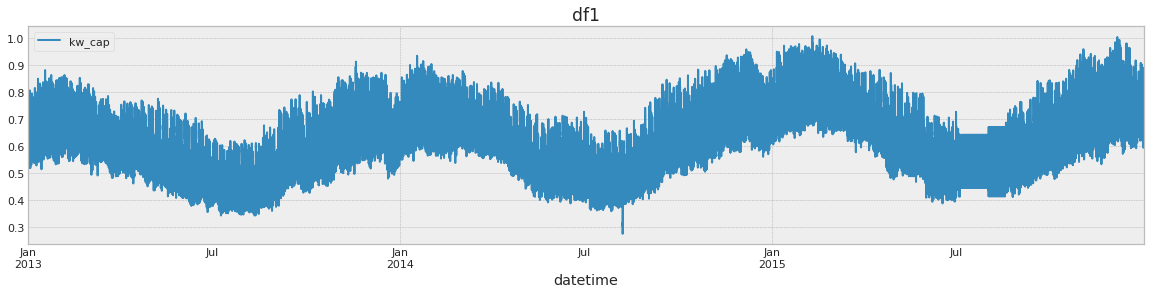

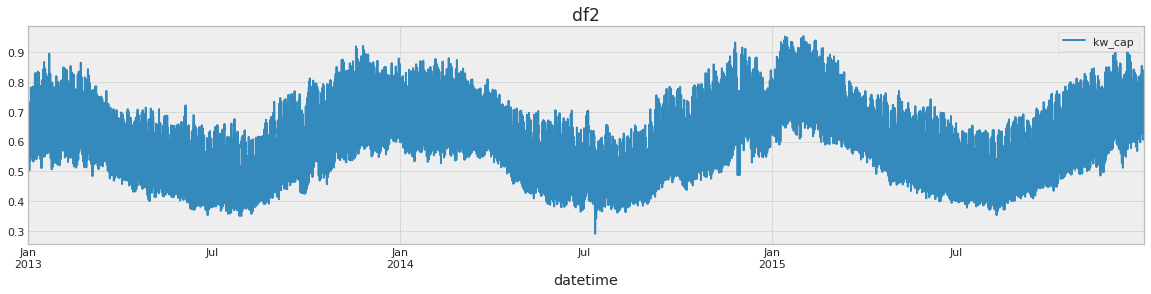

In [ ]:
import statsmodels.api as sm

def plot_dfs(rang=range(1,10)):
  if not isinstance(rang, range):
    print('rang need to be a range object')
  for i in rang:
    data = globals()['df'+str(i)][['datetime', 'kw_cap']].set_index('datetime')
    fig = data.plot(figsize=(20, 4), title='df'+str(i))
    # fig.savefig(fig_root+'df'+str(i)+'.png')
    print(fig)
    # plt.show()

plot_dfs(rang=range(1,3))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


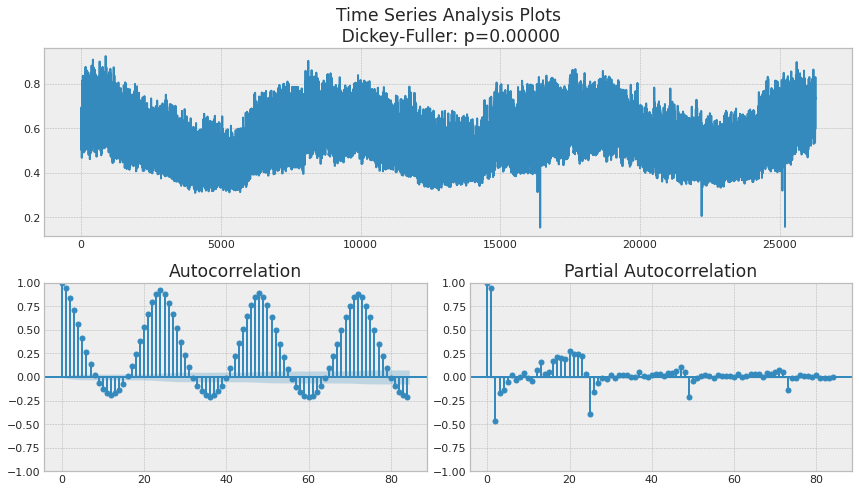

In [ ]:
tsplot(df9.kw_cap, lags=24*7*0.5)

## Split the data

In [ ]:
# # No more missing data
# len(s1)-365*3*24

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
s1 = df1.kw_cap
test_len = int(len(s1)*0.2)
s1_train, s1_test = temporal_train_test_split(s1, test_size=test_len)
len(s1_test)

5256

## Define moving average

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast."""
  mov = np.cumsum(series)
  # the past $window_size number of data points, the series has to be a Numpy array, 
  # which is quite different from Pandas Series
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

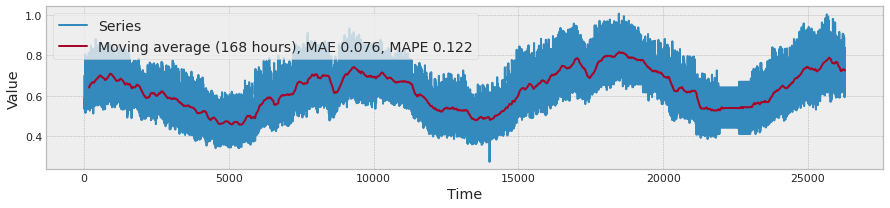

In [ ]:
def plot_mvag_w_data(window_size=24*7, col=df1.kw_cap):
  moving_avg = moving_average_forecast(np.array(col), window_size)
  mape = mean_absolute_percentage_error(moving_avg, col[-len(moving_avg):])
  mae = mean_absolute_error(moving_avg, col[-len(moving_avg):])

  plt.figure(figsize=(15, 3))
  plot_series(range(len(col)), col, label="Series")
  plot_series(range(window_size, len(col)), moving_avg, label=f"Moving average ({window_size} hours), MAE {mae:.3f}, MAPE {mape:.3f}")

plot_mvag_w_data()

## Aggregate by the date

In [ ]:
def data_aggregator(df=df2, groupby_col='date', col='kw_cap'):
  try:
    df_agg = df.groupby(groupby_col)[col].sum().reset_index()
    df_agg = df_agg.sort_values(by=groupby_col)
    return df_agg    
  except:
    print('groupby_col and col must be column names')
  
data_aggregator(df=df2)

,date,kw_cap
0,2013-01-01 00:00:00,14.401937
1,2013-01-02 00:00:00,14.323593
2,2013-01-03 00:00:00,15.207853
3,2013-01-04 00:00:00,15.868703
4,2013-01-05 00:00:00,15.592633
...,...,...
1090,2015-12-27 00:00:00,16.617928
1091,2015-12-28 00:00:00,17.055963
1092,2015-12-29 00:00:00,17.301963
1093,2015-12-30 00:00:00,17.092092


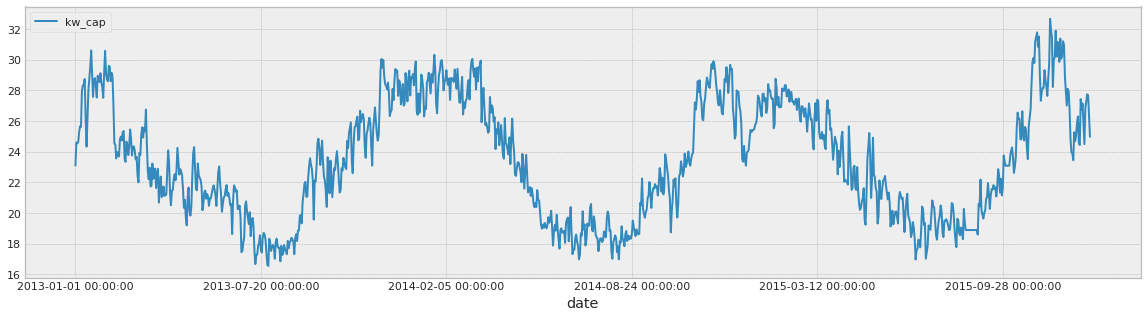

In [ ]:
import statsmodels.api as sm

data = data_aggregator(df=df4).set_index('date')
data.plot(figsize=(20, 5))
plt.show()

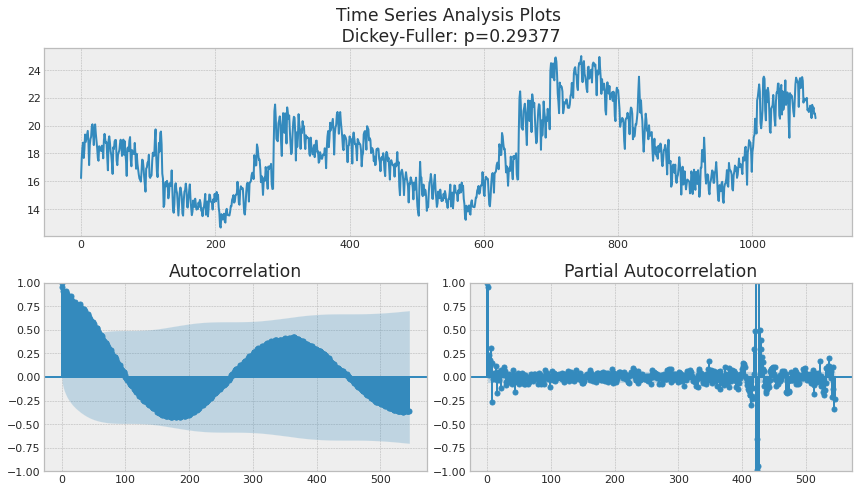

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import statsmodels.graphics.tsaplots as smt

warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
tsplot(data_aggregator(df=df3).kw_cap, lags=545)

### It becomes static after taking the difference of 1, what about taking the difference of, say 30?

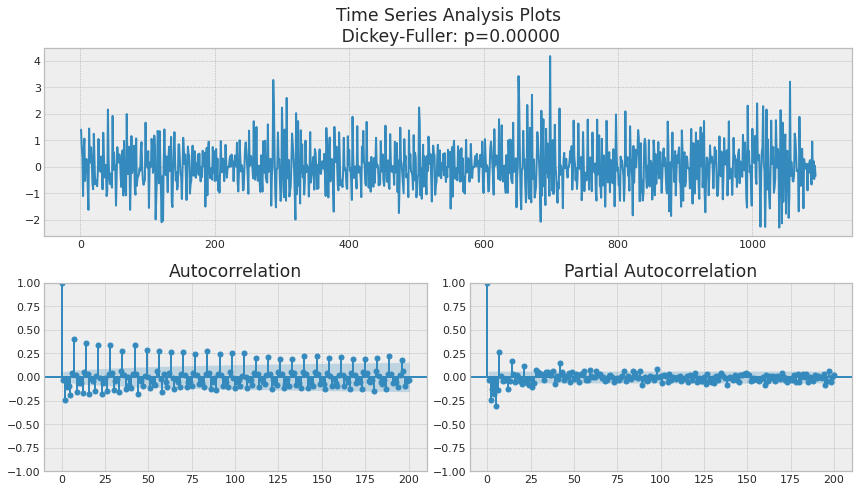

In [ ]:
s2_agg_diff = (data_aggregator(df=df3).kw_cap - data_aggregator(df=df3).kw_cap.shift(1)).dropna()
tsplot(s2_agg_diff, lags=50*4)